In [48]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
from datetime import timedelta

# Load dataset
df = pd.read_csv("D:\\Neural_Network\\DataSets\\Bajaj Finserv.csv")

# Parse the "Date" column
df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y', errors='coerce')

# Drop rows where 'Date' could not be parsed
df.dropna(subset=['Date'], inplace=True)

# Prepare the data
n_timesteps = 3
relevant_columns = df.columns.difference(['Date'])
features = df[relevant_columns].values

# Scaling the features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)

X = scaled_data[:-1]  # Use all rows except the last one
y = scaled_data[1:, relevant_columns.get_loc('close')]  # Predict the next value of 'close', so shift 'close' values by one step

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.306, random_state=42)

# Reshape input data for LSTM (since we are using only one feature)
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

# Build the LSTM model
model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.1),
    LSTM(units=50, return_sequences=True),
    Dropout(0.1),
    LSTM(units=50),
    Dropout(0.1),
    Dense(units=1)  # Output layer with 1 unit for predicting the next 'Close' value
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=44, validation_data=(X_test, y_test))

# Predict
predicted_prices = model.predict(X_test)

# Inverse transform the scaled values to their original scale
y_test_original = scaler.inverse_transform(np.concatenate([X_test[:, 0, :-1], y_test.reshape(-1, 1)], axis=1))[:, -1]
predicted_prices_original = scaler.inverse_transform(np.concatenate([X_test[:, 0, :-1], predicted_prices], axis=1))[:, -1]

# Extract the dates for the test set
test_start_idx = len(df) - len(y_test)
test_dates = df['Date'].iloc[test_start_idx:].values


# Evaluate model performance
mse = mean_squared_error(y_test, predicted_prices)
r2 = r2_score(y_test, predicted_prices)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

Epoch 1/50


C:\Users\shiva\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


38/38 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 0.1091 - val_loss: 0.0192
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0165 - val_loss: 0.0026
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0026 - val_loss: 5.7724e-04
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0029 - val_loss: 3.2297e-04
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0022 - val_loss: 3.3293e-04
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0013 - val_loss: 2.7289e-04
Epoch 8/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 2.6537e-04
Epoch 9/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0015 - val_loss: 1.6762e-04
Epoch 10/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0023 - val_loss: 1.5285e-04
Epoch 11/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0012 - val_loss: 1.6444e-04
Epoch 12/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step -

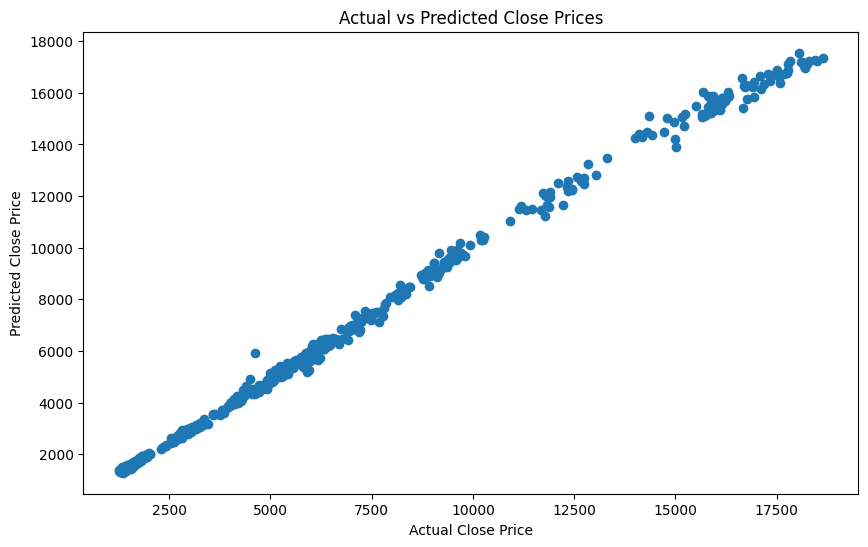

In [49]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test_original, predicted_prices_original)
plt.xlabel('Actual Close Price')
plt.ylabel('Predicted Close Price')
plt.title('Actual vs Predicted Close Prices')
plt.show()

In [50]:
last_data_point = X_test[-1:]  # Shape (1, timesteps, features)

# Predict the next day's price
predicted_next_day_price = model.predict(last_data_point)

# Reshape for inverse transformation
predicted_next_day_price_reshaped = predicted_next_day_price.reshape(-1, 1)
last_data_point_reshaped = last_data_point.reshape(-1, last_data_point.shape[-1])
new_data_point = np.zeros_like(last_data_point_reshaped)

# Replace the last feature with the predicted next day's price
new_data_point[:, -1] = predicted_next_day_price_reshaped

# Concatenate features from the last data point with the predicted next day price
concat_next_day_pred = np.concatenate((last_data_point_reshaped, predicted_next_day_price_reshaped), axis=1)

# Inverse transform to get the actual predicted next day price
predicted_next_day_actual = scaler.inverse_transform(new_data_point)[:, -1]

# Determine the date for the predicted next day price
last_date = df['Date'].iloc[-1]  # The last date in your dataset
next_date = last_date + timedelta(days=1)  # Calculate the next day's date

print(f"Predicted next day's stock price ({next_date.strftime('%Y-%m-%d')}):", predicted_next_day_actual[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted next day's stock price (2024-06-26): 1647.6728286036848
